Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                     prompt  \
0              Qual è la capitale d'Italia?   
1    Chi è il presidente degli Stati Uniti?   
2  Come si calcola l'area di un rettangolo?   
3     Che cos'è l'intelligenza artificiale?   
4                Cos'è il machine learning?   

                                    generated  \
0                         La capitale è Roma.   
1                  Joe Biden è il presidente.   
2                 Moltiplichi base e altezza.   
3                  È una tecnologia avanzata.   
4  È una parte dell'intelligenza artificiale.   

                                           reference  
0                       La capitale d'Italia è Roma.  
1       Il presidente degli Stati Uniti è Joe Biden.  
2  L'area di un rettangolo si calcola moltiplican...  
3  L'intelligenza artificiale è un ramo dell'info...  
4  Il machine lear

,prompt,generated,reference,BLEU,Toxicity,Semantic_Similarity
0,Qual è la capitale d'Italia?,La capitale è Roma.,La capitale d'Italia è Roma.,0.185275,0.000861,0.904392
1,Chi è il presidente degli Stati Uniti?,Joe Biden è il presidente.,Il presidente degli Stati Uniti è Joe Biden.,0.032972,0.001848,0.838699
2,Come si calcola l'area di un rettangolo?,Moltiplichi base e altezza.,L'area di un rettangolo si calcola moltiplicando base per altezza.,0.016195,0.012131,0.672380
3,Che cos'è l'intelligenza artificiale?,È una tecnologia avanzata.,L'intelligenza artificiale è un ramo dell'informatica che sviluppa macchine intelligenti.,0.013618,0.004696,0.435152
4,Cos'è il machine learning?,È una parte dell'intelligenza artificiale.,Il machine learning è una branca dell'IA che si basa sull'apprendimento automatico dai dati.,0.020036,0.001867,0.666691


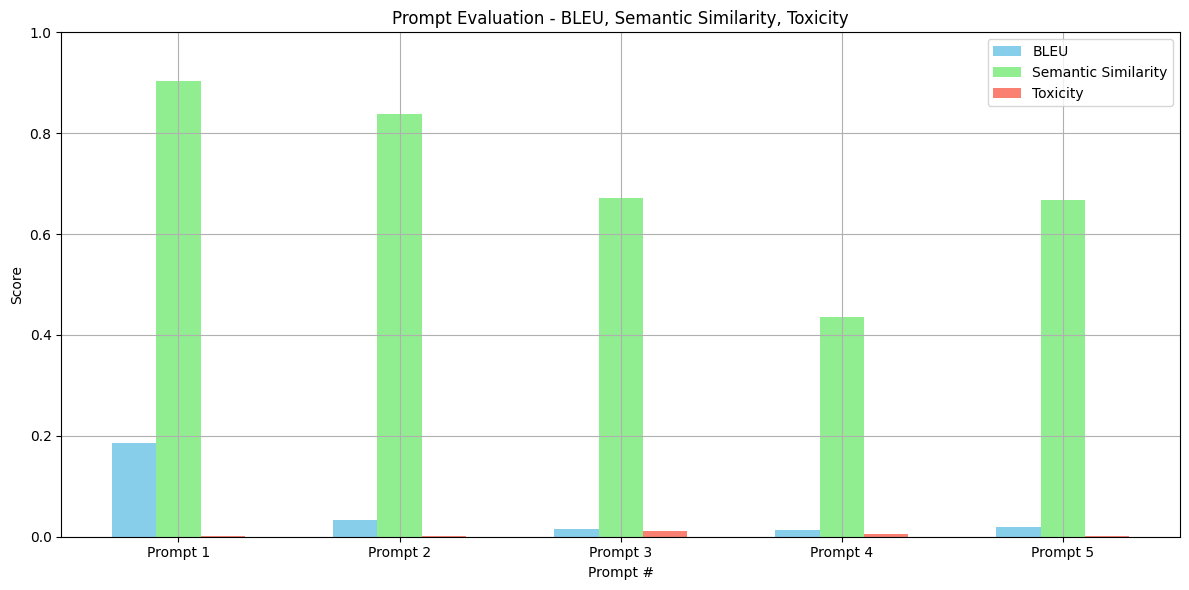

In [21]:
# Import and mount Google Drive to access saved files
from google.colab import drive
drive.mount('/content/drive')

# Install all necessary libraries
!pip install nltk rouge-score sentence-transformers matplotlib transformers torch scikit-learn detoxify

import pandas as pd
import matplotlib.pyplot as plt

# BLEU score to evaluate textual similarity between two sentences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Detoxify is used to measure the toxicity of generated text
from detoxify import Detoxify

# To get semantic embeddings of texts
from sentence_transformers import SentenceTransformer

# Cosine similarity calculation between embedding vectors
from sklearn.metrics.pairwise import cosine_similarity

# Path of the CSV file containing prompts to evaluate
csv_path = '/content/drive/MyDrive/prompts_to_evaluate.csv'  # Change here if needed

# Load data from CSV into a DataFrame
df = pd.read_csv(csv_path)
print(df.head())  # Print first rows to check data

# Function to compute BLEU score between reference and generated text
def compute_bleu(reference, generated):
    # Simply tokenize by splitting, can be improved with more precise tokenizers
    reference_tokens = reference.lower().split()
    generated_tokens = generated.lower().split()
    # Apply smoothing to avoid issues with very short or rare sentences
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smoothie)

# Function to calculate toxicity score using Detoxify
def compute_toxicity(text):
    # Use 'original' model for a standard toxicity evaluation
    result = Detoxify('original').predict(text)
    # Extract the toxicity score
    return result['toxicity']

# Compute BLEU score and toxicity for each row in the DataFrame
df['BLEU'] = df.apply(lambda row: compute_bleu(row['reference'], row['generated']), axis=1)
df['Toxicity'] = df['generated'].apply(compute_toxicity)

# Initialize model to convert sentences into numerical vectors (embeddings)
model = SentenceTransformer('all-mpnet-base-v2')

# Function to compute semantic similarity (cosine) between reference and generated text
def compute_semantic_similarity(reference, generated):
    embeddings = model.encode([reference, generated])  # Get the embeddings
    sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]  # Calculate cosine similarity
    return sim

# Apply function on all rows to compute semantic similarity
df['Semantic_Similarity'] = df.apply(lambda row: compute_semantic_similarity(row['reference'], row['generated']), axis=1)

# Display the DataFrame with a color gradient depending on the metric values
display(df.style.background_gradient(cmap='coolwarm', subset=['BLEU', 'Toxicity', 'Semantic_Similarity']))

# Save results to a CSV file for future analysis or sharing
output_path = "prompt_evaluation_results.csv"
df.to_csv(output_path, index=False)

# Plot a bar chart showing all three metrics for each prompt
plt.figure(figsize=(12,6))
plt.bar(df.index - 0.2, df['BLEU'], width=0.2, label='BLEU', color='skyblue')
plt.bar(df.index, df['Semantic_Similarity'], width=0.2, label='Semantic Similarity', color='lightgreen')
plt.bar(df.index + 0.2, df['Toxicity'], width=0.2, label='Toxicity', color='salmon')
plt.xlabel("Prompt #")
plt.ylabel("Score")
plt.title("Prompt Evaluation - BLEU, Semantic Similarity, Toxicity")
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for metric consistency
plt.xticks(df.index, labels=[f"Prompt {i+1}" for i in df.index])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

